# Training LeNet-5 on CIFAR-10
In this notebook, we will try to deploy the famous LeNet-5 to solve a simple image classification task, the CIFAR-10. CIFAR-10 is composed of 60K images from 10 categories. After splitting the dataset, we have 45K/5K/10K images for train/valiation/test dataset.
In this notebook, only the labels of training/validation dataset is visible to you, so you can use the training and validation data to tune your model. After you submitted your model, your final grade will be determined on the model performance on the holdout test dataset.

### Step 0 Setting up LeNet-5 model
As you have set up the LeNet-5 model in Homework 1, we will just move the implementation of LeNet-5 model here, so you can use it for this homework.

In [58]:
import argparse
import os, sys
import time
import datetime
import matplotlib.pyplot as plt


# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

In [49]:
import math
# Create the neural network module: LeNet-5
def swish(x):
      return x * F.sigmoid(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2   = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3   = nn.Linear(84, 10)
        self._initialize_weights()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.bn3(self.fc1(out)))
        out = F.relu(self.bn4(self.fc2(out)))
        out = self.fc3(out)
        return out


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * (m.in_channels + m.out_channels)
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_() 

### Step 1: Setting up preprocessing functions.
Preprocessing is very important because it prepares your data for proceeding training steps.
Write functions to load dataset and preprocess the incoming data. We recommend that the preprocess scheme \textbf{must} include normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

**mean(RGB-format): (0.4914, 0.4822, 0.4465)**

**std(RGB-format): (0.2023, 0.1994, 0.2010)**

In [50]:
# Specify preprocessing function.
# Reference mean/std value for 
transform_train  = transforms.Compose([
        transforms.RandomCrop(32, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

### Step 2: Setting up data I/O
Data I/O reads data from the dataset and prepares it for further procedures. Note that you have to link transformation with data I/O so that these operations can be interleaved. Thus, the training process can be more efficient.

In [51]:
# You cannot change this line.
from tools.dataloader import CIFAR10
# Call the dataset Loader
DATAROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=4)

Using downloaded and verified file: ./data/cifar10_trainval_F20.zip
Extracting ./data/cifar10_trainval_F20.zip to ./data
Files already downloaded and verified
Training dataset has 45000 examples!
Using downloaded and verified file: ./data/cifar10_trainval_F20.zip
Extracting ./data/cifar10_trainval_F20.zip to ./data
Files already downloaded and verified
Validation dataset has 5000 examples!


### Step 3: Instantialize your LeNet-5 model and deploy it to GPU devices.
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

In [52]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


### Hyperparameter settings
Hyperparameters are quite crucial in determining the performance of our model. The default hyperparameter settings are sufficient for a decent result. You may tune them wisely and carefully for better results.

In [53]:
# Initial learning rate
INITIAL_LR = 0.00 #originally 0.01
# Momentum for optimizer.
MOMENTUM = 0.9
# Regularization
REG = 1e-4
# Total number of training epochs
EPOCHS = 30
# Learning rate decay policy.
DECAY_EPOCHS = 2
DECAY = 1.00

### Handling weights load/save protocols.
This handles the weight loading/saving protocols.You may be able to load from checkpoints.

In [54]:

CHECKPOINT_PATH = "./saved_model"
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = True
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Training from scratch ...
Starting from learning rate 0.000000:


### Step 4 Setting up loss functions and Optimizers
Loss function is your objective to train the neural networks. Typically, we use multi-class cross entropy as objectives for classification models (e.g., CIFAR-10, MNIST). In this homework, we use SGD optimizer with momentum as our optimizer. You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.

In [55]:
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(params=net.parameters(), lr=current_learning_rate, weight_decay=REG, momentum=MOMENTUM, nesterov=False)

### Step 5: Start the training process.
Congratulations! You have completed all of the previous steps and it is time to train our neural network.
Training a neural network usually composes the following 3 parts: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU)**

**ii) Do a forward pass to get the output logits from the neural network. Compute the forward loss.**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

You will also need to compute accuracy within all these parts to justify that your model is doing well on the dataset.


In [56]:
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0
loss = 0
correct_examples = 0
total_examples = 0

for batch_idx, (inputs, targets) in enumerate(trainloader):
  inputs = inputs.to(device)
  targets = targets.to(device)
  # Zero the gradient
  optimizer.zero_grad()
  # Generate output
  outputs = net(inputs)
  loss_temp = criterion(outputs, targets)
  loss += loss_temp.item()
  _, predicted = outputs.max(1)
  total_examples += predicted.size(0)
  correct_examples += predicted.eq(targets).sum().item()

avg_acc = correct_examples / total_examples
print("Loss before training is: ", loss/ (batch_idx + 1), " , Training Accuracy: ", avg_acc)


for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    
    # Train the training dataset for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        l1_crit = nn.L1Loss(size_average=False)
        #reg_loss = 0
        #for param in net.parameters():
          #reg_loss += torch.sum(param)
        #print(reg_loss)
        loss = criterion(outputs, targets) #+ REG * reg_loss
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        total_examples += predicted.size(0)
        correct_examples += predicted.eq(targets).sum().item()
        train_loss += loss
        global_step += 1
                
    avg_loss = train_loss / (batch_idx + 1)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)            
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            total_examples += predicted.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # Handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

Loss before training is:  2.304512866518714  , Training Accuracy:  0.09684444444444444
2020-09-13 02:00:06.293043
Epoch 0:


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training loss: 2.3048, Training accuracy: 0.0966
2020-09-13 02:00:18.516129
Validation...
Validation loss: 2.3046, Validation accuracy: 0.0990
Saving ...
2020-09-13 02:00:19.605706
Epoch 1:
Training loss: 2.3049, Training accuracy: 0.0981
2020-09-13 02:00:31.775261
Validation...
Validation loss: 2.3051, Validation accuracy: 0.0970
2020-09-13 02:00:32.864122
Epoch 2:
Training loss: 2.3047, Training accuracy: 0.0978
2020-09-13 02:00:45.117243
Validation...
Validation loss: 2.3050, Validation accuracy: 0.0978
Current learning rate has decayed to 0.000000
2020-09-13 02:00:46.199388
Epoch 3:
Training loss: 2.3048, Training accuracy: 0.0970
2020-09-13 02:00:58.390862
Validation...
Validation loss: 2.3049, Validation accuracy: 0.0982
2020-09-13 02:00:59.459968
Epoch 4:
Training loss: 2.3047, Training accuracy: 0.0972
2020-09-13 02:01:11.529511
Validation...
Validation loss: 2.3051, Validation accuracy: 0.0960
Current learning rate has decayed to 0.000000
2020-09-13 02:01:12.611712
Epoch 5:
Tr

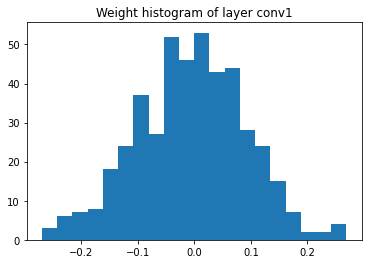

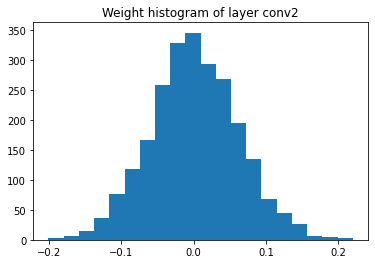

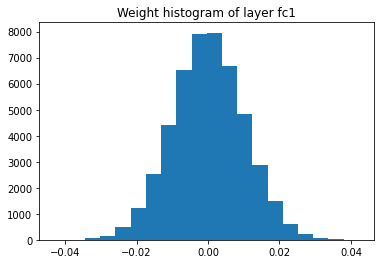

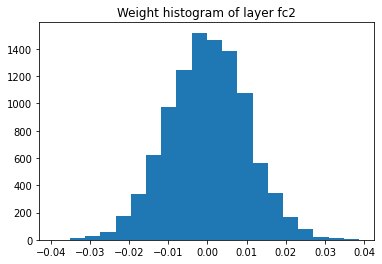

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


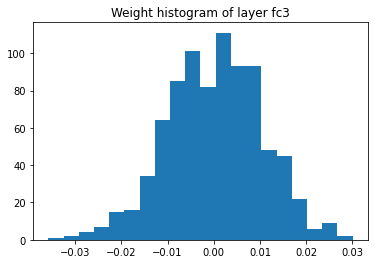

In [61]:
for name, module in net.named_modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
    # Get the weight of the module as a NumPy array
    weight = module.weight.cpu().detach().numpy()
    # Reshape for histogram
    weight = weight.reshape(-1)
    _ = plt.hist(weight, bins=20)
    plt.title("Weight histogram of layer "+name)
    plt.show()